In [1]:

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip gdrive/My\ Drive/VQA-Med-Train

Archive:  gdrive/My Drive/VQA-Med-Train.zip
   creating: ImageClef-2019-VQA-Med-Training/
  inflating: ImageClef-2019-VQA-Med-Training/All_QA_Pairs_train.txt  
  inflating: ImageClef-2019-VQA-Med-Training/train_ImageIDs.txt  
   creating: ImageClef-2019-VQA-Med-Training/Train_images/
  inflating: ImageClef-2019-VQA-Med-Training/Train_images/synpic27944.jpg  
  inflating: ImageClef-2019-VQA-Med-Training/Train_images/synpic18635.jpg  
  inflating: ImageClef-2019-VQA-Med-Training/Train_images/synpic28603.jpg  
  inflating: ImageClef-2019-VQA-Med-Training/Train_images/synpic24684.jpg  
  inflating: ImageClef-2019-VQA-Med-Training/Train_images/synpic21681.jpg  
  inflating: ImageClef-2019-VQA-Med-Training/Train_images/synpic17734.jpg  
  inflating: ImageClef-2019-VQA-Med-Training/Train_images/synpic59158.jpg  
  inflating: ImageClef-2019-VQA-Med-Training/Train_images/synpic46205.jpg  
  inflating: ImageClef-2019-VQA-Med-Training/Train_images/synpic53801.jpg  
  inflating: ImageClef-2019-VQA

In [3]:
!unzip gdrive/My\ Drive/VQA-Med-Val

Archive:  gdrive/My Drive/VQA-Med-Val.zip
   creating: ImageClef-2019-VQA-Med-Validation/
  inflating: ImageClef-2019-VQA-Med-Validation/All_QA_Pairs_val.txt  
  inflating: ImageClef-2019-VQA-Med-Validation/val_ImageIDs.txt  
  inflating: ImageClef-2019-VQA-Med-Validation/.DS_Store  
   creating: ImageClef-2019-VQA-Med-Validation/QAPairsByCategory/
  inflating: ImageClef-2019-VQA-Med-Validation/QAPairsByCategory/C2_Plane_val.txt  
  inflating: ImageClef-2019-VQA-Med-Validation/QAPairsByCategory/C1_Modality_val.txt  
  inflating: ImageClef-2019-VQA-Med-Validation/QAPairsByCategory/C3_Organ_val.txt  
  inflating: ImageClef-2019-VQA-Med-Validation/QAPairsByCategory/C4_Abnormality_val.txt  
   creating: ImageClef-2019-VQA-Med-Validation/Val_images/
  inflating: ImageClef-2019-VQA-Med-Validation/Val_images/synpic48351.jpg  
  inflating: ImageClef-2019-VQA-Med-Validation/Val_images/synpic43576.jpg  
  inflating: ImageClef-2019-VQA-Med-Validation/Val_images/synpic59005.jpg  
  inflating: Imag

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout, Activation, Flatten, Reshape, Concatenate, Multiply, Lambda, Add, RepeatVector, Permute, Bidirectional, TimeDistributed
from tensorflow.keras.models import Model
encoder_cnn = tf.keras.applications.resnet_rs.ResNetRS50(include_top=False, weights='imagenet', input_shape=(224,224,3))
encoder_cnn.trainable = True
intermediate_layer = encoder_cnn.get_layer('BlockGroup4__block_5__output_act')

img_regions_layer = tf.keras.layers.Reshape((196,1024))(intermediate_layer.output)
print(img_regions_layer.shape)

# apply dense layer to each of the 196 regions
dense_layer = tf.keras.layers.Dense(1024, activation='relu')(img_regions_layer)
# apply dropout
# dense_layer = tf.transpose(dense_layer, perm=[0, 2, 1])
dropout_layer = tf.keras.layers.Dropout(0.5)(dense_layer)
print(dropout_layer.shape)



135360144/135360144 [==============================] - 7s 0us/step
(None, 196, 1024)
(None, 196, 1024)


In [5]:
latent_dim = 1024
embedding_dim = 100
vocab_size = 99
max_len = 11


encoder_inputs = Input(shape=(max_len,))
enc_emb = Embedding(99, embedding_dim, trainable=True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.2,recurrent_dropout=0.2)
(encoder_outputs, state_h, state_c) = encoder_lstm(enc_emb)



In [6]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.WI_A = Dense(units, activation='tanh',use_bias = False)
        self.WQ_A = Dense(units, activation='tanh',use_bias = True)
        self.WP = Dense(1, activation='softmax',use_bias = False)

    # def get_config(self):
    #     config = super().get_config().copy()
    #     config.update({
    #         'units' : self.units,
    #     })
    #     return config

    def call(self, features, hidden):
        question_l1 = self.WQ_A(hidden) # (batch_size, units)
        question_l1 = tf.expand_dims(question_l1, 1)
        # print("q : ",question_l1.shape)
        image_l1 = self.WI_A(features) # (batch_size, 196, units)
        # print("i : ",image_l1.shape)
        # image_l2 = tf.transpose(image_l1, perm=[0, 2, 1]) # (batch_size, units, 196)
        # print(image_l2.shape)
        activation = tf.keras.activations.tanh(question_l1 + image_l1) # (batch_size, units, 196)
        # print("a : ",activation.shape)
        pI = self.WP(activation)  # (batch_size, 196,1)
        # print("pi : " ,pI.shape)

        # sigma(pivi)
        # # each pi from 196 regions has to get multiplied with its corresponding vi and then summed up
        # vIbar = Multiply()([pI, features]) # (batch_size, 196, 512)
        # print("vibar ", vIbar.shape)
        # vIbar = tf.reduce_sum(vIbar, axis=-1,keepdims=True) # (batch_size, 512)
        # print("vibar  : ",vIbar.shape)
        vIbar = tf.matmul(tf.transpose(features,perm=[0,2,1]),pI) # (batch_size, 1, 512)
        # print("vibar  : ",vIbar.shape)
        vIbar = tf.squeeze(vIbar, axis=-1)
        # print("vibar  : ",vIbar.shape)
        # print("hidden : ",hidden.shape)
        # vIbar = tf.squeeze(vIbar, axis=-1)
        # print("vibar  : ",vIbar.shape)
        refined_question = Add()([vIbar, hidden]) # (batch_size, 512)
        # print("kll,",refined_question.shape)
        return refined_question






attention_layer = Attention(1024)
# see an example of the output shape
# print(dropout_layer.shape)

refined_query = attention_layer(dropout_layer, state_h)


decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(1985, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.2,recurrent_dropout=0.2)
(decoder_outputs, _, _) = decoder_lstm(dec_emb, initial_state=[refined_query, state_c])

decoder_dense = TimeDistributed(Dense(1985, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs,encoder_cnn.input, decoder_inputs], decoder_outputs)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 226, 226, 3)          0         ['normalization[0][0]']   

In [14]:
# CONVERT THE TEXT FILE SEPERATED BY | TO A DATAFRAME
import pandas as pd
import numpy as np
import json
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

file_path = './VQA-Med-Train/All_QA_Pairs_train.txt'
# Read the text file into a list of lines
with open(file_path, 'r') as file:
    lines = file.readlines()

# Use list comprehension to split lines and create a list of dictionaries
data_list = [line.strip().split('|') for line in lines]

# Create a DataFrame directly from the list of dictionaries
train_qa_df = pd.DataFrame(data_list, columns=['image', 'question', 'answer'])

# Print the DataFrame
train_qa_df.shape

(12792, 3)

In [13]:
file_path = './VQA-Med-Val/All_QA_Pairs_val.txt'
# Read the text file into a list of lines
with open(file_path, 'r') as file:
    lines = file.readlines()

# Use list comprehension to split lines and create a list of dictionaries
data_list = [line.strip().split('|') for line in lines]

# Create a DataFrame directly from the list of dictionaries
val_qa_df = pd.DataFrame(data_list, columns=['image', 'question', 'answer'])

# Print the DataFrame
val_qa_df.shape


(2000, 3)

In [ ]:

# val_qa[0]['image']
# val_image_path = []
# for i in val_qa:
#     val_image_path.append('pvqa/images/val/'+i['image'] + '.jpg')


In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer

import string
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split

# import spacy
from time import time
import numpy as np

In [11]:

import re

def text_strip(sentence):
    sentence = re.sub("(//t)", ' ', str(sentence)).lower()
    sentence = re.sub("(//r)", ' ', str(sentence)).lower()
    sentence = re.sub("(//n)", ' ', str(sentence)).lower()
    sentence = re.sub("(__+)", ' ', str(sentence)).lower()
    sentence = re.sub("(--+)", ' ', str(sentence)).lower()
    sentence = re.sub("(\.\.+)", ' ', str(sentence)).lower()
    sentence = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(sentence)).lower()
    sentence = re.sub(r"(\\x9\d)", ' ', str(sentence)).lower()
    sentence = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", ' ', str(sentence)).lower()
    sentence = re.sub("(\.\s+)", ' ', str(sentence)).lower()
    sentence = re.sub("(\-\s+)", ' ', str(sentence)).lower()
    sentence = re.sub("(\:\s+)", ' ', str(sentence)).lower()
    sentence = re.sub("(\?\s+)", ' ', str(sentence)).lower()
    sentence = re.sub("(\s+.\s+)", ' ', str(sentence)).lower()
    sentence = re.sub("(\s+)", ' ', str(sentence)).lower()
    return sentence


In [15]:
train_qa_df["cleaned_question"] = train_qa_df["question"].apply(lambda x: text_strip(x))
train_qa_df["cleaned_answer"] = train_qa_df["answer"].apply(lambda x: '_START_ '+ text_strip(x) + ' _END_')
train_qa_df["cleaned_answer"] = train_qa_df["cleaned_answer"].apply(lambda x: 'sostok '+x+' eostok')

train_qa_df.head()



,image,question,answer,cleaned_question,cleaned_answer
0,synpic41148,what kind of image is this?,cta - ct angiography,what kind of image is this,sostok _START_ cta ct angiography _END_ eostok
1,synpic43984,is this a t1 weighted image?,no,is this t1 weighted image,sostok _START_ no _END_ eostok
2,synpic38930,what type of imaging modality is used to acqui...,us - ultrasound,what type of imaging modality is used to acqui...,sostok _START_ us ultrasound _END_ eostok
3,synpic52143,is this a noncontrast mri?,no,is this noncontrast mri,sostok _START_ no _END_ eostok
4,synpic20934,what type of image modality is this?,xr - plain film,what type of image modality is this,sostok _START_ xr plain film _END_ eostok


In [16]:

val_qa_df["cleaned_question"] = val_qa_df["question"].apply(lambda x: text_strip(x))
val_qa_df["cleaned_answer"] = val_qa_df["answer"].apply(lambda x: '_START_ '+ text_strip(x) + ' _END_')
val_qa_df["cleaned_answer"] = val_qa_df["cleaned_answer"].apply(lambda x: 'sostok '+x+' eostok')

val_qa_df.head()

,image,question,answer,cleaned_question,cleaned_answer
0,synpic54733,what imaging modality was used to take this im...,ct with iv contrast,what imaging modality was used to take this im...,sostok _START_ ct with iv contrast _END_ eostok
1,synpic25647,what kind of scan is this?,xr - plain film,what kind of scan is this,sostok _START_ xr plain film _END_ eostok
2,synpic35681,was the mri taken with contrast?,no,was the mri taken with contrast,sostok _START_ no _END_ eostok
3,synpic39641,"is this a t1 weighted, t2 weighted, or flair i...",t2,is this t1 weighted t2 weighted or flair image,sostok _START_ t2 _END_ eostok
4,synpic35693,is this a noncontrast mri?,yes,is this noncontrast mri,sostok _START_ yes _END_ eostok


<ipython-input-17-64fd96f8cf0c>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_qa_df['question_len'],kde=False,bins=50,color='blue')


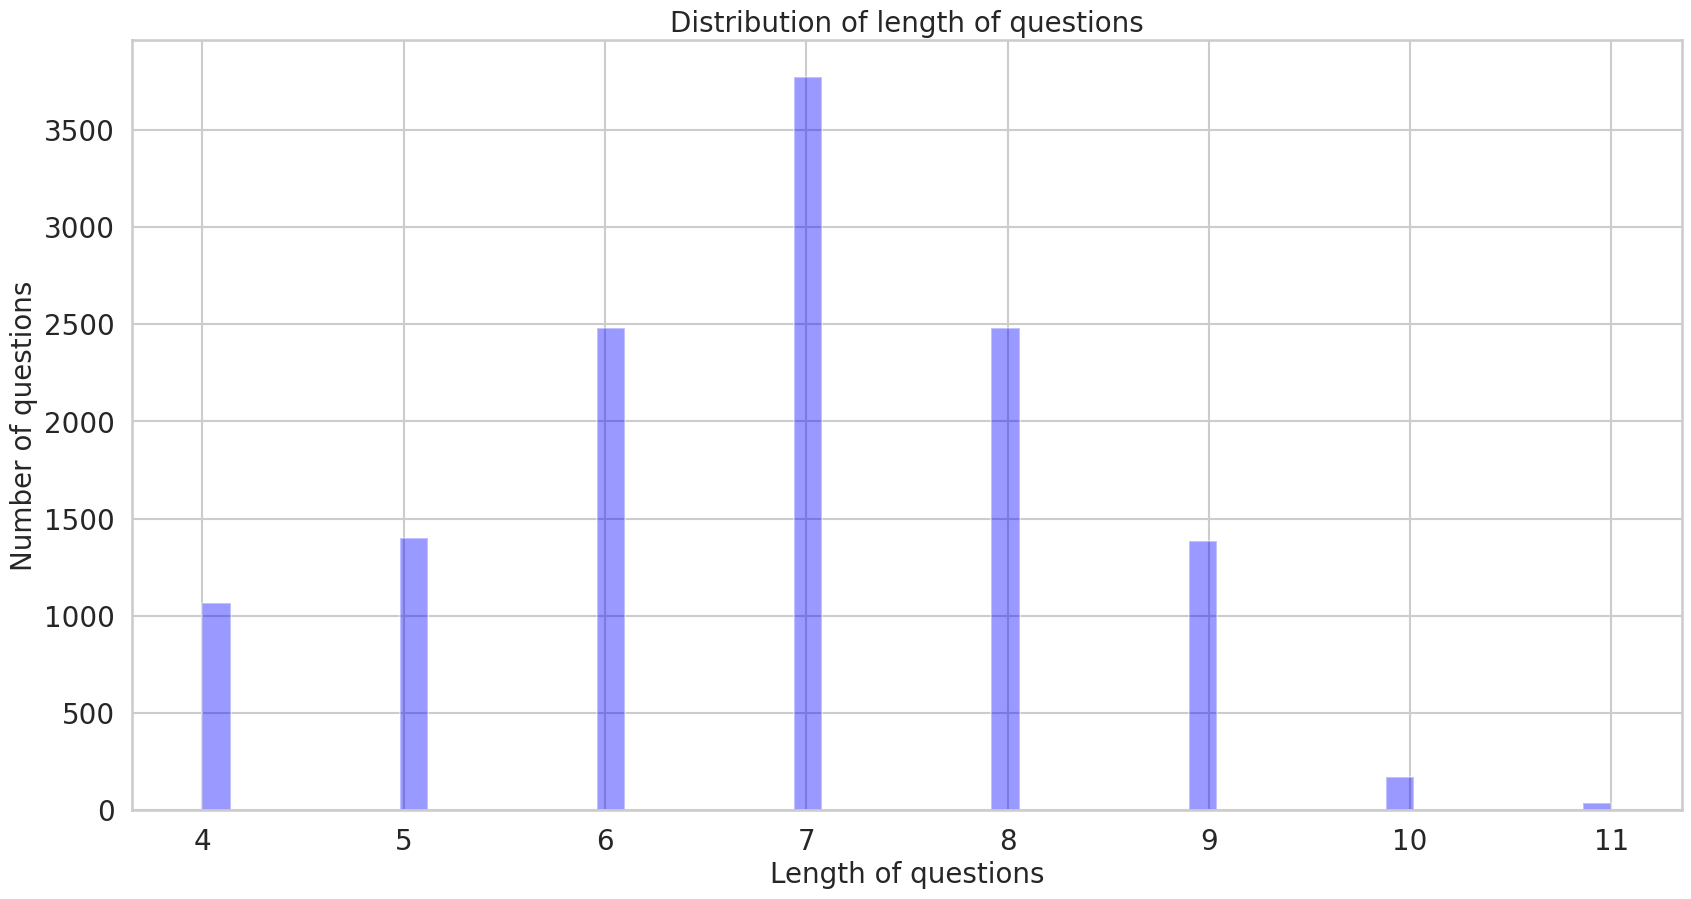

<ipython-input-17-64fd96f8cf0c>:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_qa_df['answer_len'],kde=False,bins=50,color='red')


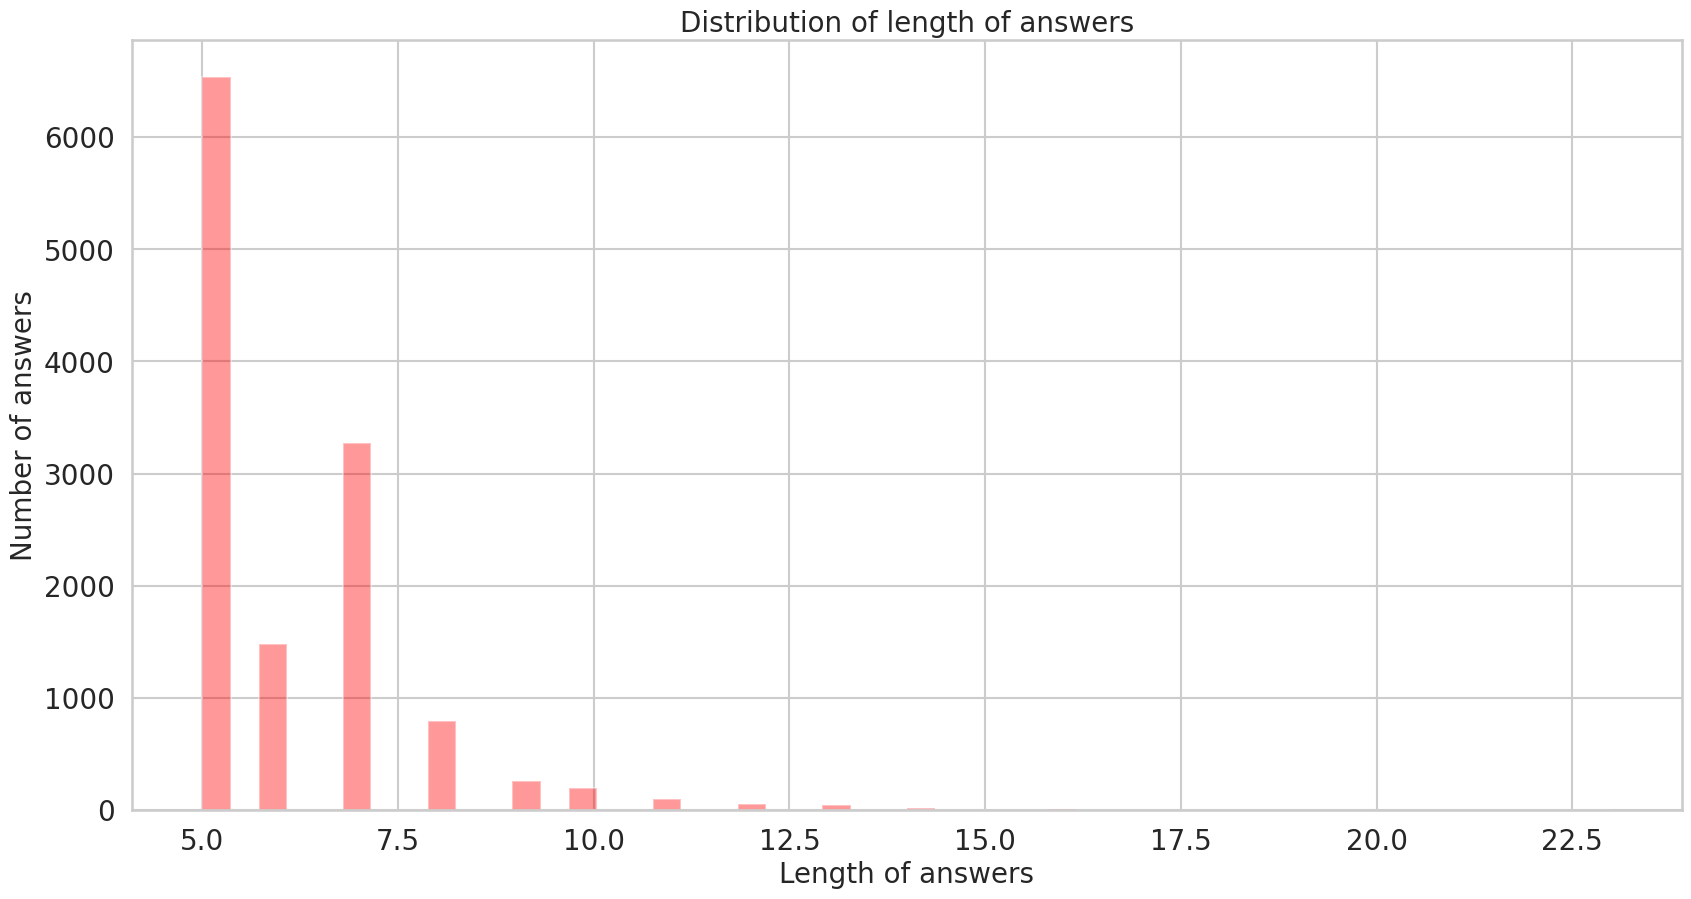

count    12792.000000
mean         6.800422
std          1.461771
min          4.000000
25%          6.000000
50%          7.000000
75%          8.000000
max         11.000000
Name: question_len, dtype: float64
count    12792.000000
mean         6.122342
std          1.553153
min          5.000000
25%          5.000000
50%          5.000000
75%          7.000000
max         23.000000
Name: answer_len, dtype: float64
Number of questions with length greater than 11:  0
Number of answers with length greater than 15:  23


In [17]:
#know the distribution of length of questions and answers
train_qa_df['question_len'] = train_qa_df['cleaned_question'].apply(lambda x:len(x.split()))
train_qa_df['answer_len'] = train_qa_df['cleaned_answer'].apply(lambda x:len(x.split()))

#plot the distribution of length of questions and answers
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')
plt.figure(figsize=(20, 10))
sns.distplot(train_qa_df['question_len'],kde=False,bins=50,color='blue')
plt.title('Distribution of length of questions', fontsize=20)
plt.xlabel('Length of questions', fontsize=20)
plt.ylabel('Number of questions', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()


plt.figure(figsize=(20, 10))
sns.distplot(train_qa_df['answer_len'],kde=False,bins=50,color='red')
plt.title('Distribution of length of answers', fontsize=20)
plt.xlabel('Length of answers', fontsize=20)
plt.ylabel('Number of answers', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

# see the detailed distribution of length of questions and answers
print(train_qa_df['question_len'].describe())

# see the detailed distribution of length of questions and answers
print(train_qa_df['answer_len'].describe())

# see how many of questions has length greater than 25
print('Number of questions with length greater than 11: ',len(train_qa_df[train_qa_df['question_len']>11]))


# see how many of answers has length greater than 25
print('Number of answers with length greater than 15: ',len(train_qa_df[train_qa_df['answer_len']>15]))



<ipython-input-18-029cbe63663e>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(val_qa_df['question_len'],kde=False,bins=50,color='blue')


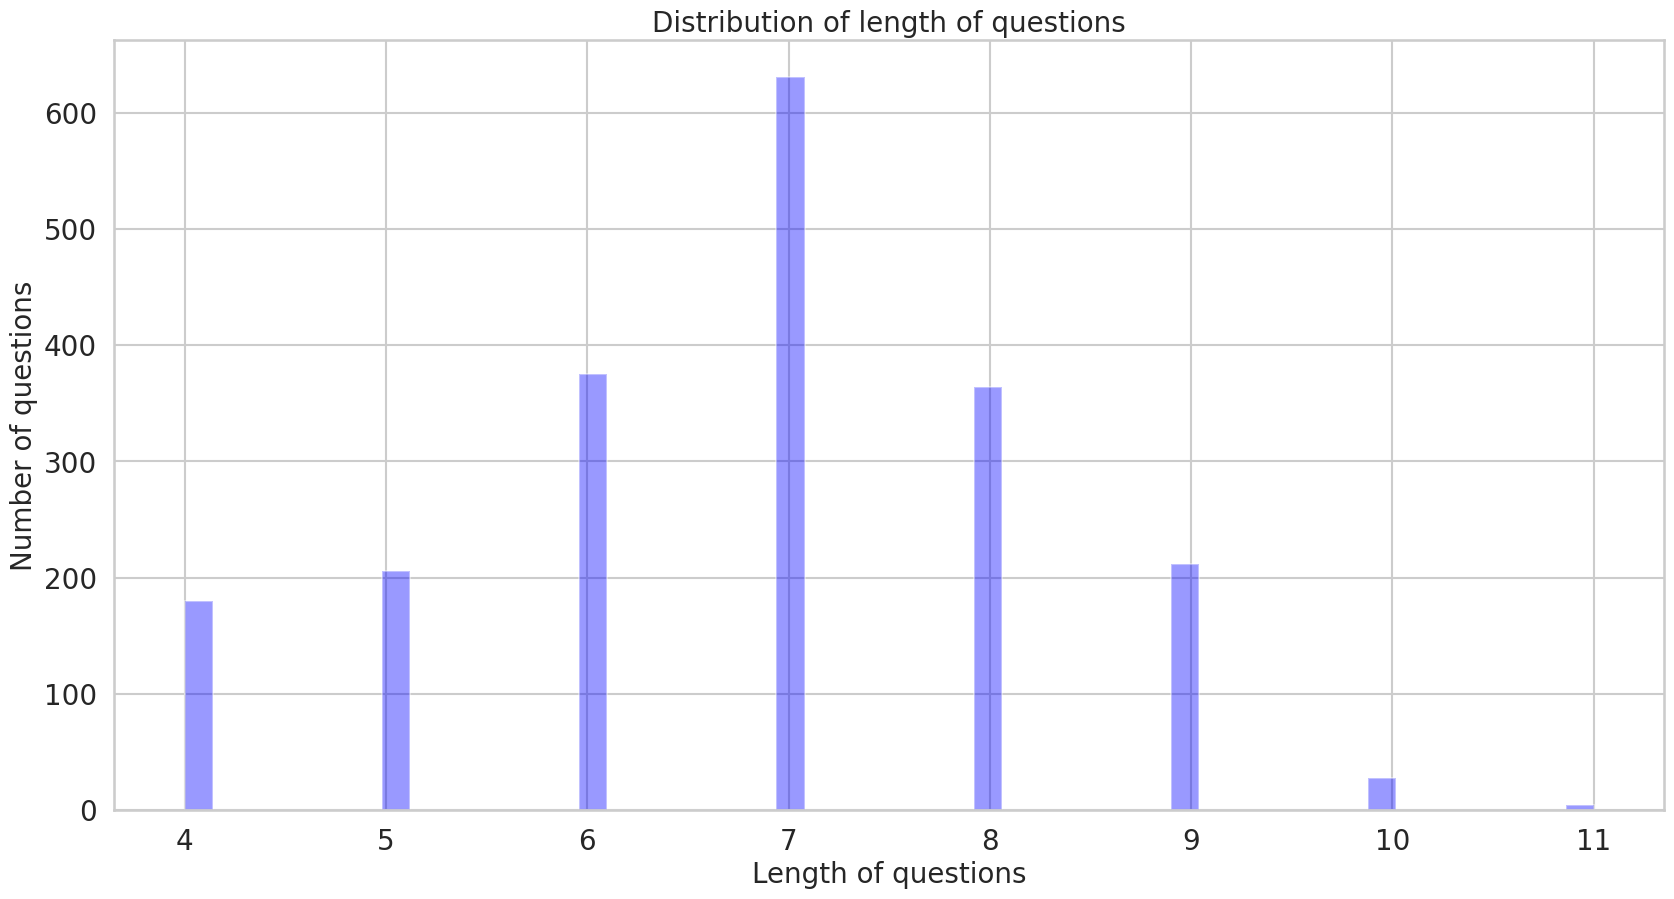

<ipython-input-18-029cbe63663e>:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(val_qa_df['answer_len'],kde=False,bins=50,color='red')


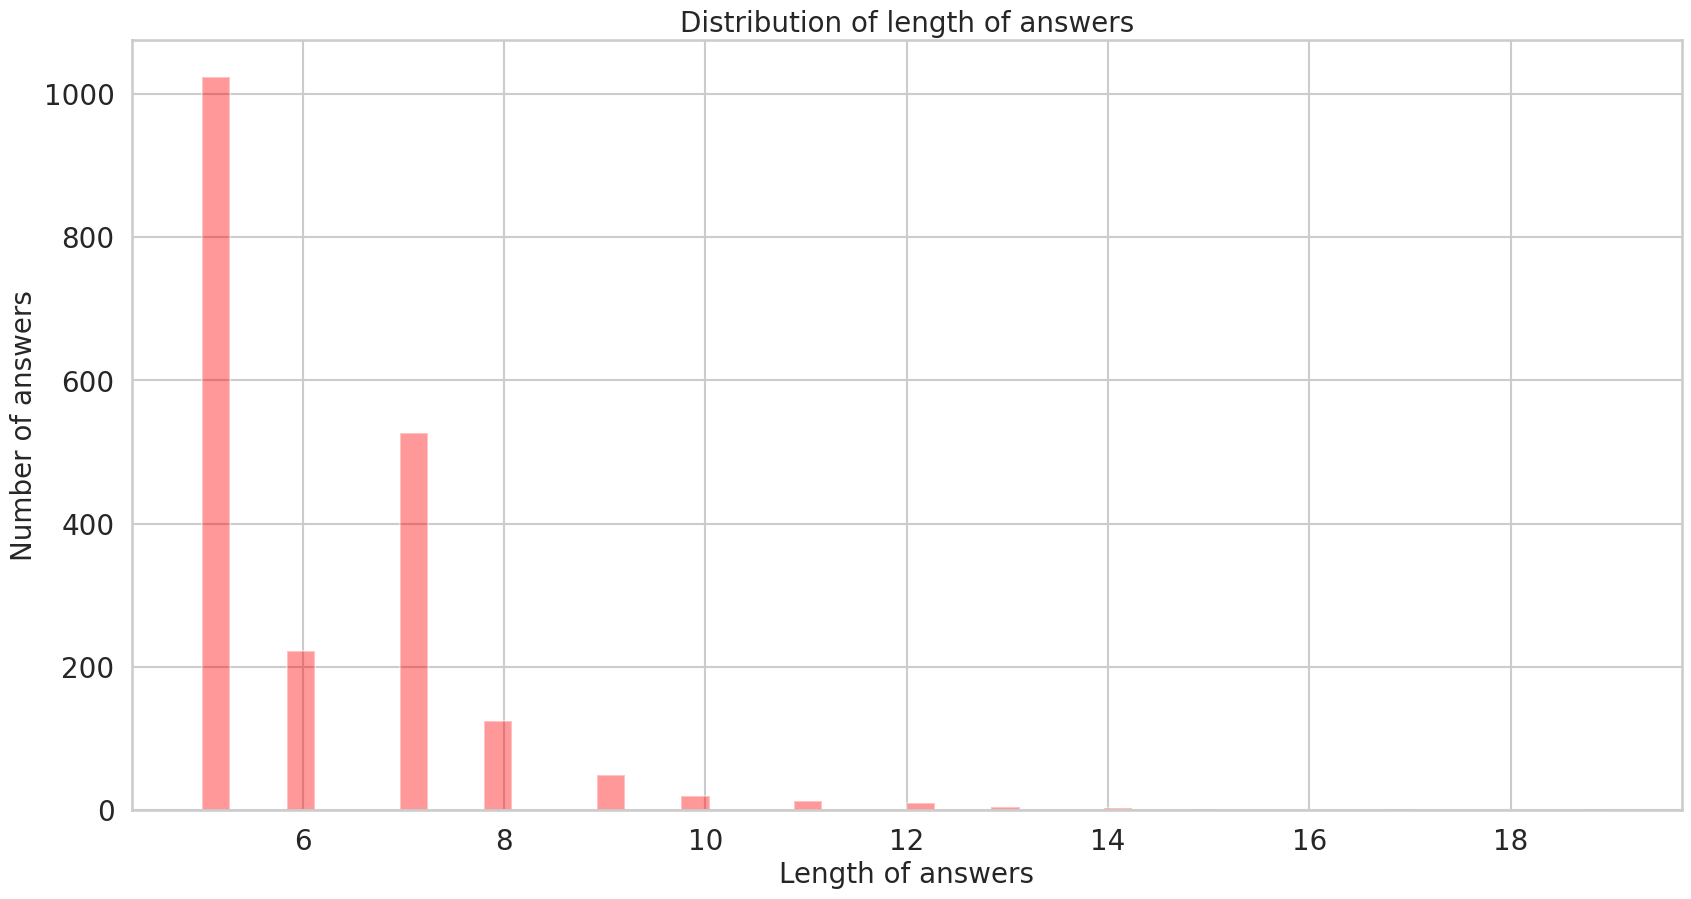

count    2000.000000
mean        6.780500
std         1.458212
min         4.000000
25%         6.000000
50%         7.000000
75%         8.000000
max        11.000000
Name: question_len, dtype: float64
count    2000.000000
mean        6.102500
std         1.489665
min         5.000000
25%         5.000000
50%         5.000000
75%         7.000000
max        19.000000
Name: answer_len, dtype: float64
Number of questions with length greater than 11:  4
Number of answers with length greater than 15:  3


In [18]:
#know the distribution of length of questions and answers
val_qa_df['question_len'] = val_qa_df['cleaned_question'].apply(lambda x:len(x.split()))
val_qa_df['answer_len'] = val_qa_df['cleaned_answer'].apply(lambda x:len(x.split()))

#plot the distribution of length of questions and answers
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')
plt.figure(figsize=(20, 10))
sns.distplot(val_qa_df['question_len'],kde=False,bins=50,color='blue')
plt.title('Distribution of length of questions', fontsize=20)
plt.xlabel('Length of questions', fontsize=20)
plt.ylabel('Number of questions', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()


plt.figure(figsize=(20, 10))
sns.distplot(val_qa_df['answer_len'],kde=False,bins=50,color='red')
plt.title('Distribution of length of answers', fontsize=20)
plt.xlabel('Length of answers', fontsize=20)
plt.ylabel('Number of answers', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

# see the detailed distribution of length of questions and answers
print(val_qa_df['question_len'].describe())

# see the detailed distribution of length of questions and answers
print(val_qa_df['answer_len'].describe())

# see how many of questions has length greater than 25
print('Number of questions with length greater than 11: ',len(val_qa_df[val_qa_df['question_len']>=11]))


# see how many of answers has length greater than 25
print('Number of answers with length greater than 15: ',len(val_qa_df[val_qa_df['answer_len']>15]))


In [19]:
print(train_qa_df.shape)
post_qa = train_qa_df[((train_qa_df.cleaned_question.str.split().str.len() <= 11) &
                       (train_qa_df.cleaned_answer.str.split().str.len() <= 15))].copy()
post_qa = post_qa.reset_index(drop=True)
print(post_qa.shape)

post_qa = post_qa.drop(['question_len','answer_len','question','answer'],axis=1)
# we can pass the cleaned_question and cleaned_answer to the encoder and images to the CNN encoder model
post_qa = post_qa.rename(columns = {'cleaned_question' : 'question', 'cleaned_answer' : 'answer'})

post_qa

(12792, 7)
(12769, 7)


,image,question,answer
0,synpic41148,what kind of image is this,sostok _START_ cta ct angiography _END_ eostok
1,synpic43984,is this t1 weighted image,sostok _START_ no _END_ eostok
2,synpic38930,what type of imaging modality is used to acqui...,sostok _START_ us ultrasound _END_ eostok
3,synpic52143,is this noncontrast mri,sostok _START_ no _END_ eostok
4,synpic20934,what type of image modality is this,sostok _START_ xr plain film _END_ eostok
...,...,...,...
12764,synpic35685,is this image normal,sostok _START_ yes _END_ eostok
12765,synpic35687,is there something wrong in the image,sostok _START_ no _END_ eostok
12766,synpic35701,is there evidence of any abnormalities,sostok _START_ no _END_ eostok
12767,synpic48036,is the ct scan normal,sostok _START_ yes _END_ eostok


In [20]:
print(val_qa_df.shape)
post_val_qa = val_qa_df[((val_qa_df.cleaned_question.str.split().str.len() <= 11) &
                       (val_qa_df.cleaned_answer.str.split().str.len() <= 15))].copy()
post_val_qa = post_val_qa.reset_index(drop=True)
print(post_val_qa.shape)

post_val_qa = post_val_qa.drop(['question_len','answer_len','question','answer'],axis=1)
# we can pass the cleaned_question and cleaned_answer to the encoder and images to the CNN encoder model
post_val_qa = post_val_qa.rename(columns = {'cleaned_question' : 'question', 'cleaned_answer' : 'answer'})

post_val_qa

(2000, 7)
(1997, 7)


,image,question,answer
0,synpic54733,what imaging modality was used to take this im...,sostok _START_ ct with iv contrast _END_ eostok
1,synpic25647,what kind of scan is this,sostok _START_ xr plain film _END_ eostok
2,synpic35681,was the mri taken with contrast,sostok _START_ no _END_ eostok
3,synpic39641,is this t1 weighted t2 weighted or flair image,sostok _START_ t2 _END_ eostok
4,synpic35693,is this noncontrast mri,sostok _START_ yes _END_ eostok
...,...,...,...
1992,synpic45828,what is abnormal in the mri,sostok _START_ marked hydrocephalus due to aqu...
1993,synpic60458,what is abnormal in the x-ray,sostok _START_ discoid meniscus _END_ eostok
1994,synpic43524,what is most alarming about this mri,sostok _START_ choroid plexus neoplasm papillo...
1995,synpic59568,what is abnormal in the mri,sostok _START_ multiple sclerosis _END_ eostok


In [21]:
def get_rare_words(text_col):
    text_tokenizer = Tokenizer()
    text_tokenizer.fit_on_texts(list(text_col))
    thresh = 2
    cnt = 0
    tot_cnt = 0

    for key, value in text_tokenizer.word_counts.items():
        print(key,value)
        tot_cnt = tot_cnt + 1
        if value < thresh:
            cnt = cnt + 1

    print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
    return cnt, tot_cnt

In [22]:
x_train_rare, x_train_tot = get_rare_words(post_qa['question'])

what 9712
kind 93
of 1434
image 5533
is 10979
this 7395
t1 412
weighted 597
type 403
imaging 882
modality 1085
used 810
to 601
acquire 66
the 5348
noncontrast 394
mri 2071
with 419
taken 1269
was 1262
contrast 573
or 445
ct 1830
scan 1616
mr 136
weighting 136
in 5466
shown 934
does 178
represent 36
an 174
gi 63
given 131
patient 186
take 404
seen 1116
did 55
have 55
picture 27
which 1190
how 128
iv 68
method 37
here 451
t2 389
flair 258
plane 3200
ultrasound 244
x 539
ray 539
film 100
acquired 111
captured 247
mammograph 24
demonstrated 121
depicted 112
displayed 249
nuclear 23
medicine 23
oriented 106
angiogram 91
gastrointestinal 61
pet 4
organ 2770
by 133
system 2055
primarily 292
present 159
imaged 743
shows 127
one 134
part 430
body 430
show 122
visualized 135
pictured 144
evaluated 288
systems 155
can 155
be 155
being 456
showing 148
principally 146
abnormal 792
abnormality 1515
primary 732
most 765
alarming 765
about 765
look 20
normal 61
there 49
something 13
wrong 13
are 13
ab

In [23]:
x_tokenizer = Tokenizer(num_words=x_train_tot-x_train_rare)
x_tokenizer.fit_on_texts(list(post_qa['question']))

x_train_seq = x_tokenizer.texts_to_sequences(post_qa['question'])
x_val_seq = x_tokenizer.texts_to_sequences(post_val_qa['question'])
x_train_pad = pad_sequences(x_train_seq,  maxlen=11, padding='post')
x_val_pad = pad_sequences(x_val_seq, maxlen=15, padding='post')

x_voc = x_tokenizer.num_words + 1
print("size of vocabulary in X = {}".format(x_voc))


size of vocabulary in X = 99


In [24]:
y_train_rare, y_train_tot = get_rare_words(post_qa['answer'])


sostok 12769
start 12769
cta 45
ct 237
angiography 69
end 12770
eostok 12769
no 679
us 196
ultrasound 199
xr 456
plain 456
film 456
noncontrast 205
yes 615
t2 258
w 77
contrast 197
iv 167
mr 323
flair 140
mammograph 24
with 158
gi 57
and 2018
t1 131
weighted 77
t1w 68
gadolinium 29
an 83
angiogram 78
mra 24
venography 24
nm 18
nuclear 19
medicine 19
dwi 30
diffusion 30
other 22
pulse 22
seq 22
gd 10
fat 14
suppressed 7
ugi 14
upper 16
adc 16
map 16
app 16
diff 16
coeff 16
bas 23
barium 33
swallow 23
pet 5
positron 3
emission 3
pdw 18
proton 18
density 18
be 10
enema 10
d 13
doppler 13
stir 5
venogram 3
gradient 6
gre 6
mpgr 6
swan 6
swi 6
fiesta 3
myelogram 2
sbft 7
small 28
bowel 18
axial 1558
longitudinal 51
coronal 391
lateral 166
ap 197
sagittal 481
mammo 22
mlo 9
pa 93
cc 13
transverse 82
mag 2
frontal 120
oblique 50
3d 22
reconstruction 22
decubitus 2
lung 277
mediastinum 251
pleura 251
skull 1234
contents 1450
genitourinary 214
spine 256
musculoskeletal 436
heart 125
great 121
v

In [25]:
y_tokenizer = Tokenizer(num_words=y_train_tot)
y_tokenizer.fit_on_texts(list(post_qa['answer']))

y_train_seq = y_tokenizer.texts_to_sequences(post_qa['answer'])
y_val_seq = y_tokenizer.texts_to_sequences(post_val_qa['answer'])
y_train_pad = pad_sequences(y_train_seq, maxlen=11, padding='post')
y_val_pad = pad_sequences(y_val_seq, maxlen=15, padding='post')

y_voc = y_tokenizer.num_words + 1
print("size of vocabulary in Y = {}".format(y_voc))


size of vocabulary in Y = 1985


In [26]:
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_name = './vqa-med.h5'
save_model = ModelCheckpoint(filepath=model_name,
                             save_weights_only=False,
                             save_best_only=True,
                             verbose=1)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [27]:

def get_images(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.resnet50.preprocess_input(img)
    return img

def get_images_batch(image_path_list):
    batch_images = []
    for image_path in image_path_list:
        batch_images.append(get_images(image_path))
    batch_images = np.array(batch_images)
    return batch_images

def generate_batch(X,train_image_paths,y, batch_size = 16):
    ''' Generate a batch of data '''

    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = X[j:j+batch_size]
            img_paths = get_images_batch(train_image_paths[j : j+batch_size])
            target_text = y[j:j+batch_size]
            decoder_input_data = target_text[:,:-1]

            decoder_target_data =target_text.reshape(target_text.shape[0],target_text.shape[1], 1)[:,1:]
            yield [encoder_input_data,img_paths, decoder_input_data], decoder_target_data
batch_size = 32
epochs = 100
train_samples = len(x_train_pad)
val_samples = len(x_val_pad)

train_image_paths = []
for i in post_qa['image']:
    train_image_paths.append('VQA-Med-Train/Train_images/'+i + '.jpg')

val_image_paths = []
for i in post_val_qa['image']:
    val_image_paths.append('VQA-Med-Val/Val_images/'+i + '.jpg')

history = model.fit_generator(generator=generate_batch(x_train_pad,train_image_paths, y_train_pad, batch_size = batch_size),
                    steps_per_epoch=train_samples//batch_size,
                    epochs=epochs,
                    validation_data=generate_batch(x_val_pad,val_image_paths, y_val_pad, batch_size = batch_size),
                    validation_steps=val_samples//batch_size,
                    callbacks=[save_model, es],
                    verbose=1)

# history = model.fit([x_train_pad, get_images_batch(train_image_paths), y_train_pad[:,:-1]], y_train_pad.reshape(y_train_pad.shape[0],y_train_pad.shape[1], 1)[:,1:],
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     validation_data=([x_val_pad, get_images_batch(val_image_paths), y_val_pad[:,:-1]], y_val_pad.reshape(y_val_pad.shape[0],y_val_pad.shape[1], 1)[:,1:]) ,
#                     callbacks=[save_model, es],
#                     verbose=1)

# history = model.fit_generator


<ipython-input-27-66bdfe063256>:39: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=generate_batch(x_train_pad,train_image_paths, y_train_pad, batch_size = batch_size),


Epoch 1/100
399/399 [==============================] - ETA: 0s - loss: 1.0544 - accuracy: 0.4998
Epoch 1: val_loss improved from inf to 1.01846, saving model to ./vqa-med.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


399/399 [==============================] - 288s 586ms/step - loss: 1.0544 - accuracy: 0.4998 - val_loss: 1.0185 - val_accuracy: 0.6393
Epoch 2/100
399/399 [==============================] - ETA: 0s - loss: 0.7836 - accuracy: 0.4895
Epoch 2: val_loss improved from 1.01846 to 0.90021, saving model to ./vqa-med.h5
399/399 [==============================] - 213s 529ms/step - loss: 0.7836 - accuracy: 0.4895 - val_loss: 0.9002 - val_accuracy: 0.6390
Epoch 3/100
399/399 [==============================] - ETA: 0s - loss: 0.6433 - accuracy: 0.4893
Epoch 3: val_loss improved from 0.90021 to 0.86116, saving model to ./vqa-med.h5
399/399 [==============================] - 210s 526ms/step - loss: 0.6433 - accuracy: 0.4893 - val_loss: 0.8612 - val_accuracy: 0.6392
Epoch 4/100
399/399 [==============================] - ETA: 0s - loss: 0.5730 - accuracy: 0.4894
Epoch 4: val_loss improved from 0.86116 to 0.81897, saving model to ./vqa-med.h5
399/399 [==============================] - 209s 523ms/step - 

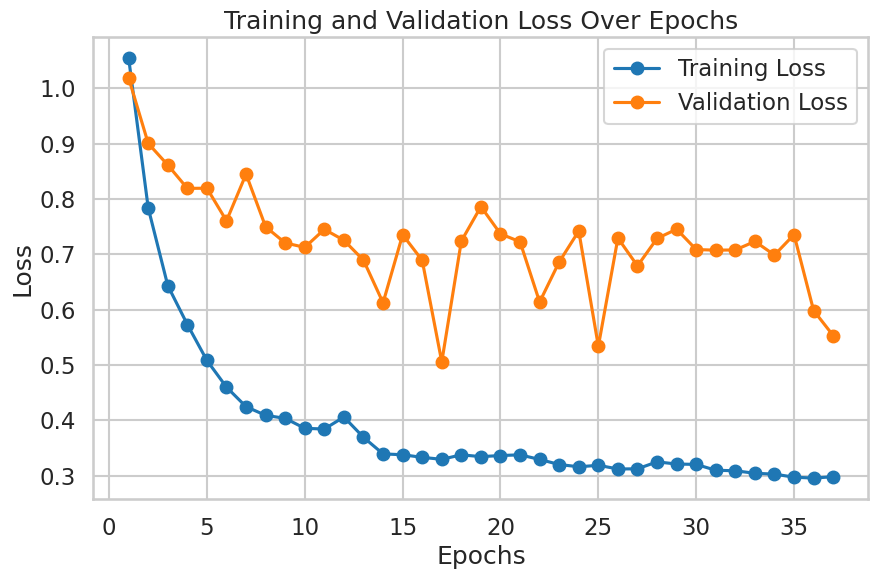

In [29]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker='o', linestyle='-')

# Customize the plot
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In [ ]:
model.save('vMed.h5')

In [ ]:
model.load_weights('pqva-3.h5')

In [ ]:
attention = model.get_layer('attention_1')

In [ ]:
img_encoder = model.get_layer('BlockGroup4__block_5__output_act')

In [ ]:
img_encoder.get_weights()

[]

In [ ]:
attention

[array([[-0.00257574,  0.03551754,  0.01517748, ...,  0.0004929 ,
         -0.0506087 ,  0.0406676 ],
        [-0.03095125,  0.01535126,  0.02077091, ..., -0.03839245,
          0.04046128, -0.03907113],
        [ 0.03681931, -0.02733283, -0.00106724, ...,  0.00281047,
          0.0005467 , -0.03897792],
        ...,
        [-0.01713647, -0.05038318, -0.00279505, ..., -0.00531117,
          0.01874406, -0.01202875],
        [ 0.02264515,  0.04992231, -0.02376024, ...,  0.05303794,
          0.02506031,  0.01724083],
        [ 0.05334656,  0.00120002,  0.037819  , ..., -0.03541465,
          0.04043591,  0.04545117]], dtype=float32),
 array([[-0.05078839,  0.01132618,  0.05370698, ...,  0.01212437,
          0.01257869, -0.00788626],
        [ 0.03066633,  0.03628254, -0.03563254, ..., -0.03679907,
          0.02433096,  0.03520718],
        [ 0.04772189,  0.05406834, -0.05082883, ...,  0.0124932 ,
         -0.00404326,  0.02790349],
        ...,
        [-0.04995124,  0.01839178,  0.0

In [ ]:
img = get_images('./VQA-Med-Train/Train_images/synpic100108.jpg')
print(img)

[[[  -1.939003   130.22101    121.32     ]
  [  -1.939003   130.22101    121.32     ]
  [  -2.939003   129.22101    120.32     ]
  ...
  [  -2.939003   126.221      106.32     ]
  [ -10.939003   118.221       98.32     ]
  [  -3.939003   122.221      111.32     ]]

 [[-100.939     -107.779     -103.68     ]
  [-100.939     -107.779     -103.68     ]
  [-100.939     -107.779     -103.68     ]
  ...
  [  27.060997     8.221001     2.3199997]
  [ 114.061       95.221       89.32     ]
  [  71.061       49.221       52.32     ]]

 [[ -93.939     -107.779     -104.68     ]
  [ -93.939     -107.779     -104.68     ]
  [ -93.939     -107.779     -104.68     ]
  ...
  [  96.061       82.221       77.32     ]
  [ 100.061       86.221       81.32     ]
  [  57.060997    41.221       43.32     ]]

 ...

 [[  61.060997    48.221       41.32     ]
  [  67.061       54.221       47.32     ]
  [  71.061       58.221       51.32     ]
  ...
  [  82.061       69.221       62.32     ]
  [  86.061       

In [ ]:
img.shape

(224, 224, 3)

In [ ]:
q = text_strip('what modality is used to take this image?')

In [ ]:
q

'what modality is used to take this image '

In [ ]:
import tensorflow as tf
import numpy as np

# Load your trained model
model = tf.keras.models.load_model('vqa-med.h5')

# Define a function for preprocessing image data
def preprocess_image(image_path):
    # Load and preprocess the image (resize, normalize, etc.)
    image = get_images(image_path)  # Implement this function
    return image

# Define a function for preprocessing questions
def preprocess_question(question):
    # Tokenize and preprocess the question (convert to integers, pad, etc.)
    question = text_strip(question)
    q = x_tokenizer.texts_to_sequences(question)
    q = pad_sequences(q,  maxlen=11, padding='post')
    return q

# Define a function for post-processing answers
def postprocess_answer(predictions):
    # Convert predicted indices to actual answers

    answers = decode_predictions(predictions)  # Implement this function
    return answers

# Sample data (image file path and question)
sample_image_path = 'sample.jpg'
sample_question = 'What is in the image?'

# Preprocess the image and question
sample_image = preprocess_image(sample_image_path)
sample_question = preprocess_question(sample_question)

# Reshape the image and question for the model input
sample_image = np.expand_dims(sample_image, axis=0)  # Add batch dimension
sample_question = np.expand_dims(sample_question, axis=0)  # Add batch dimension

# Perform inference
predictions = model.predict([sample_question, sample_image])

# Post-process the predictions to get answers
answers = postprocess_answer(predictions)

# Print the predicted answers
print("Predicted Answers:", answers)


In [33]:
!cp vqa-med.h5 '/content/gdrive/My Drive/vqa-med.h5'